In [17]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.2.0


In [12]:
num_inputs = 2
num_examples = 1000
# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b  #wx+b真实
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),dtype=torch.float32) #1000, +随机

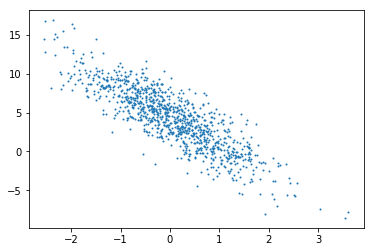

In [24]:
# 使用图像来展示生成的数据
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 读取数据集


In [26]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)


In [27]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.6027,  0.3033],
        [-0.8186, -0.9138],
        [ 1.2120, -0.4481],
        [-1.1044, -0.5960],
        [-0.5144, -0.5178],
        [ 0.8129,  2.2364],
        [ 0.3260,  0.2758],
        [ 1.0183, -0.8422],
        [ 0.8653,  1.4237],
        [-0.1288, -0.9021]]) 
 tensor([-0.0479,  5.6672,  8.1465,  4.0176,  4.9211, -1.7586,  3.9119,  9.0918,
         1.0937,  6.9971])


## 初始化模型参数



In [29]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [31]:
def linreg(X, w, b): #定义模型
    return torch.mm(X, w) + b
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2
def sgd(params, lr, batch_size): #定义优化函数
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track

## 训练

In [32]:
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.038139
epoch 2, loss 0.000163
epoch 3, loss 0.000049
epoch 4, loss 0.000049
epoch 5, loss 0.000049


In [33]:
w, true_w, b, true_b

(tensor([[ 1.9998],
         [-3.3995]], requires_grad=True),
 [2, -3.4],
 tensor([4.1996], requires_grad=True),
 4.2)

# 线性回归模型使用pytorch的简洁实现


In [35]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.2.0


## 生成数据集

In [37]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

## 读取数据集

In [38]:
import torch.utils.data as Data

batch_size = 10

# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=2,              # read data in multithreading
)

In [39]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.2511, -0.4352],
        [-1.6203,  0.2234],
        [-0.0563,  0.4632],
        [-0.0237, -0.6528],
        [-0.5159, -0.0077],
        [ 0.6316,  0.3397],
        [ 1.8497, -0.7851],
        [-0.1743, -1.5143],
        [ 1.0459,  0.4028],
        [-1.4949,  0.8429]]) 
 tensor([ 6.2060,  0.2197,  2.5149,  6.3704,  3.1883,  4.3029, 10.5764,  8.9894,
         4.9129, -1.6558])


## 定义模型

In [41]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [42]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [43]:
#初始化模型参数

from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  # or you can use `net[0].bias.data.fill_(0)` to modify it directly


Parameter containing:
tensor([0.], requires_grad=True)

In [44]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0142, -0.0161]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [47]:
#定义损失函数

loss = nn.MSELoss()    # nn built-in squared loss function
                       # function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`
#定义优化函数
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 训练

In [48]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000195
epoch 2, loss: 0.000097
epoch 3, loss: 0.000139


In [49]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 2.0000, -3.4000]])
4.2 tensor([4.2010])


# 比较

In [ ]:
从零开始的实现（推荐用来学习）

能够更好的理解模型和神经网络底层的原理

使用pytorch的简洁实现

能够更加快速地完成模型的设计与实现